# March Madenss Data Crunch Competition 
## Data Description
The dataset given comprises of NCAA game records from 2002 - 2022. Each record is described by features describing the playing teams. These include team performance stats, location, ranking, coach details, etc. 

## Objective
The objective of this project is to create a model that is able to predict the winning teams for the March Madness Mens Basketball Competition most accurately.  

## Methodology
These were the steps taken to acheive the above-mentioned objective:
   1. Understanding the Data
   2. Feature Engineering 
   3. Checking for Multicollinearity
   4. Model Building and Tuning
   5. Model Evaluation

In [57]:
# Import packages 
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians
import seaborn as sns

from sklearn.model_selection import cross_val_score,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import log_loss


In [3]:
# Import dataset as pd dataframe 
# change path
mm_data = pd.read_csv('/Users/camilleso/Desktop/MarchMadness/NCAA_Tourney_2002_2022.csv')
data2023 = pd.read_csv('/Users/camilleso/Desktop/MarchMadness/NCAA_Tourney_2023-NCAA_Tourney_2023.csv')


In [4]:
#create a target variable column based on the scores 
#if team1_score > team2_score, assign a 1 to the new column 'team1_win', else assign 0

mm_data['team1_win'] = (mm_data['team1_score']>mm_data['team2_score']).astype(int)


## Understanding the data 
### PART A: Relevance of Features
It is important to determine which variables are unnecessary for the analysis. 
Upon reading documentation and studying the dataset, the following variables were removed due to these reasons: 
    
1. Have no/ weak predictive power 
    - host
    - team1_id
    - team2_id
    - team1_teamname
    - team2_teamname
    - team1_coach_id
    - team2_coach_id
    - W_Loc
    - slot

2. will have no values for games that have not been played yet
    - num_ot
    - team2_score
    - team1_score
    - coaches_before_final (as this is released after the tournament)
    - Note: team1_score and team2_score are only needed to derive the target variable (team1_wins for each game) for train and test data. Hence, these cannot be used as input variables into the model (causes bias and games that have not been played will not have this data yet) 

3. contain the same values/ meaning as other features 
    - team1_position
    - team2_position
    - strongseed 
    - weekseed 
    - team1_region 
    - team2_region 


In [5]:
# make a list of the above mentioned columns for later
remove_list = ['host', 'team1_id', 'team1_score', 'team2_id', 'team2_score', 'WLoc',  'team1_teamname', 
               'team2_teamname','team1_position', 'team2_position', 'team1_coach_id', 'team2_coach_id', 
               'slot', 'strongseed', 'weakseed', 'team1_region', 'team2_region', 'coaches_before_final',
               'num_ot'
               ]

## Understanding the data 
### PART B: Outliers, Missing Values, and Split

This next step looks at whether there a outliers (which may be due to misinput of data), missing values, and the split of wins vs losses

Note: This analysis does not need to be done on the features in the remove_list 
    

In [6]:
# Create a copy of the df without the remove_list columns 
mm_data_removed_vars = mm_data.drop(columns=[col for col in mm_data if col in remove_list])


In [7]:
# Descriptive Statistics for numeric columns
mm_data_removed_vars.describe(include=[np.number])

,team1_seed,team2_seed,season,host_lat,host_long,team1_lat,team1_long,team2_lat,team2_long,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,...,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_win
count,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.00000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.00000,1313.000000,846.000000,731.000000,837.000000,...,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.0
mean,5.233816,8.829398,2011.715156,38.094444,-91.333359,38.007113,-89.420836,37.931666,-90.041860,5.712110,8.891089,2.966489,4.207159,1.076161,1.44326,217.661081,87.926123,355.370145,158.596344,26.894136,7.559025,24.868241,7.124905,3.321401,5.518660,1.430312,2.143184,0.486672,0.681645,158.284844,81.161462,260.057121,139.868241,25.217822,8.789794,23.22620,8.537700,9.908983,9.809850,9.764636,...,36.337730,71.204156,11.147889,45.396527,32.697418,69.280136,8.388888,33.671542,33.782841,55.631003,51.376575,0.102846,0.087835,50.788950,35.875529,70.890600,10.289475,46.215938,33.103096,69.444228,8.550076,34.096615,33.994816,55.346878,51.751001,0.100513,0.089621,67.778111,67.337686,110.940821,113.279100,95.495340,93.911320,67.581618,67.175073,108.559726,109.870776,97.029055,96.333023,1.0
std,4.067196,4.622633,5.924028,4.570405,18.493800,4.315786,13.137484,4.388459,13.825832,7.043916,7.885587,4.518300,5.081624,2.230331,2.52488,207.253443,68.785999,245.131759,97.030263,31.534151,6.741734,3.957107,3.108985,5.246687,6.557543,3.234941,3.846827,1.546045,1.785555,156.267783,64.070903,206.770649,93.360435,35.326652,5.256383,3.69387,3.093855,6.682485,7.033829,6.753931,...,2.569296,3.639101,3.090269,2.771881,2.099089,2.382797,1.511529,5.581125,4.163730,4.867450,4.924948,0.017449,0.011857,2.910820,2.595724,3.630435,2.909771,2.805354,2.111735,2.480688,1.572603,5.451673,4.245399,5.275050,5.010095,0.018456,0.012590,3.542508,3.300333,4.938450,5.333211,4.360271,4.238917,3.336209,3.128214,4.988595,5.773326,4.420024,4.888850,0.0
min,1.000000,1.000000,2002.000000,25.787700,-122.681900,21.292648,-157.816607,21.292648,-157.816607,0.0000

### DESCRIPTIVE STATS
Descriptive Statistics Output shows that there are columns that have a large difference between the max value and the mean. This implies that there may be outliers -- lets visualize this using a boxplot to verify!

Presented below are the variables with large outliers: 

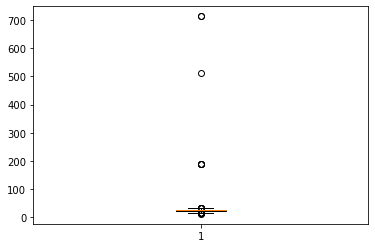

In [8]:
plt.boxplot(mm_data_removed_vars['team1_pt_team_season_wins'])
plt.show()

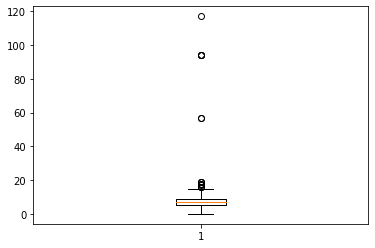

In [9]:
plt.boxplot(mm_data_removed_vars['team1_pt_team_season_losses'])
plt.show()

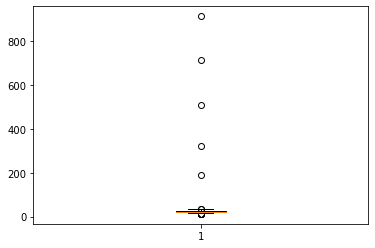

In [10]:
plt.boxplot(mm_data_removed_vars['team2_pt_team_season_wins'])
plt.show()

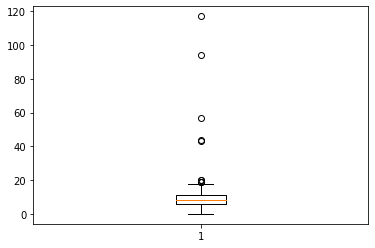

In [11]:
plt.boxplot(mm_data_removed_vars['team2_pt_team_season_losses'])
plt.show()

### OUTLIERS
Out of the 1313 records, the box plots above show that there is a marginal number of outlier values for season wins and losses for teams 1 and 2. 

Lets figure out why! 

This article posted on the official NCAA website on 2020 by Andy Wittry states that UConn and Michigan share the record for most games played in a season (41 games). Hence, the outlier values may be due to misimputation. Hence wins/ lossses above 41 should then be removed from the dataset for the analysis.


Link to the article: https://www.ncaa.com/news/basketball-men/article/2020-10-27/how-many-games-are-college-basketball-season


In [12]:
no_outlier_mm_data = mm_data_removed_vars[~(mm_data_removed_vars['team1_pt_team_season_wins'] >= 41)]
no_outlier_mm_data = no_outlier_mm_data[~(no_outlier_mm_data['team2_pt_team_season_wins'] >= 41)]
no_outlier_mm_data = no_outlier_mm_data[~(no_outlier_mm_data['team1_pt_team_season_losses'] >= 41)]
no_outlier_mm_data = no_outlier_mm_data[~(no_outlier_mm_data['team2_pt_team_season_losses'] >= 41)]



In [13]:
# There are still 1301 records left out of the 1313 from the original dataset which is sufficient enough for the analysis! 
no_outlier_mm_data.count()

team1_seed     1301
team2_seed     1301
season         1301
host_lat       1301
host_long      1301
               ... 
team2_adjoe    1301
team2_de       1301
team2_adjde    1301
game_id        1301
team1_win      1301
Length: 87, dtype: int64

In [14]:
# Checking for missing values using the values_count function
# prints columns with missing values 
for x in no_outlier_mm_data:
    nan_count = no_outlier_mm_data[x].isna().sum()
    if nan_count > 0:
        print('Number of naan values in ', x, str(nan_count))

Number of naan values in  team1_ap_final 458
Number of naan values in  team1_ap_preseason 576
Number of naan values in  team1_coaches_before_final 465
Number of naan values in  team1_coaches_preseason 610
Number of naan values in  team2_ap_final 853
Number of naan values in  team2_ap_preseason 925
Number of naan values in  team2_coaches_before_final 872
Number of naan values in  team2_coaches_preseason 942


### ASSIGNMENT FOR MISSING VALUES

The columns that have missing values are those that are related to poll rankings that are given only to the top 25 teams/ coaches. These include the following: 

- team1_ap_final 
- team1_ap_preseason 
- team1_coaches_before_final 
- team1_coaches_preseason 
- team2_ap_final 
- team2_ap_preseason 
- team2_coaches_before_final 
- team2_coaches_preseason 
    
These cannot be replaced with zeroes as lower numbered rankings are associated with better teams. 

Hence a value of 27 (a fixed value greater than the highest number ranking of 25) will be assigned to all the teams without a ranking for these categories

In [15]:
no_naan_mm_data = no_outlier_mm_data.fillna(27)

### DATASET SPLIT 
The next step is to determine whether there is an even split of wins vs loses for the target variable - which in this case is team1_wins 

In [16]:
no_naan_mm_data['team1_win'].value_counts()
#This shows that the dataset assigns team1 as the winning team for all the games. 
#Thus, half of the dataset must be transposed to switch team1 and team2 data
#The splitting of the data will be done in the later steps

1    1301
Name: team1_win, dtype: int64

## FEATURE ENGINEERING 

### Deriving the distance from home to host location
The distance between the home location of the teams and the game location can be computed for using the existing longitude and latitude of each team and game location variables. 

Several studies have supported the claim that travel time and rest have an effect on professional basketball performance. These studies include the following: 

1. Effect of travel and rest on performance of professional basketball players by Steenland K, Deddens JA.
2. The Negative Influence of Air Travel on Health and Performance in the National Basketball Association by Huyghe T, Scanlan AT, Dalbo VJ, Calleja-González J.
3. Impacts of travel distance and travel direction on back-to-back games in the National Basketball Association by Charest, J PhD and Samuels, C MD, et. al 
    
Thus, the distance from home to host will be used as an additional feature 

### Reducing Variables (Getting the difference between Team1 and Team2 numerical data)
Because team1 and team 2 have their own assigned values for the same set of variables, 
it would be more convenient to derive new variables based on the difference between team1 and team2 results.

This reduces the the number of variables in half, making it not only easier to split the data, but also make the models run more efficiently

In [17]:
# A function to derive the distance from home to host location
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [18]:
# applying the function to the dataset to derive distance for new columns (dist1 and dist2)
no_naan_mm_data['dist1'] = no_naan_mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
no_naan_mm_data['dist2'] = no_naan_mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)


In [19]:
# now the long and lat of team1, team2 and host can be dropped from the columns 
no_naan_mm_data = no_naan_mm_data.drop(columns=['team1_lat', 'team2_lat', 'team1_long', 'team2_long', 'host_long', 'host_lat'])

In [20]:
# Get the difference between all team1 and team 2 variables

no_naan_mm_data['diff_dist'] = no_naan_mm_data['dist1'] - no_naan_mm_data['dist2']
no_naan_mm_data['seed_diff'] = no_naan_mm_data['team1_seed'] - no_naan_mm_data['team2_seed']

no_naan_mm_data['pt_school_ncaa_diff'] = no_naan_mm_data['team1_pt_school_ncaa'] - no_naan_mm_data['team2_pt_school_ncaa']
no_naan_mm_data['pt_overall_ncaa_diff'] = no_naan_mm_data['team1_pt_overall_ncaa'] - no_naan_mm_data['team2_pt_overall_ncaa']
no_naan_mm_data['pt_school_s16_diff'] = no_naan_mm_data['team1_pt_school_s16'] - no_naan_mm_data['team2_pt_school_s16']
no_naan_mm_data['pt_overall_s16_diff'] = no_naan_mm_data['team1_pt_overall_s16'] - no_naan_mm_data['team2_pt_overall_s16']
no_naan_mm_data['pt_school_ff_diff'] = no_naan_mm_data['team1_pt_school_ff'] - no_naan_mm_data['team2_pt_school_ff']
no_naan_mm_data['pt_overall_ff_diff'] = no_naan_mm_data['team1_pt_overall_ff'] - no_naan_mm_data['team2_pt_overall_ff']

no_naan_mm_data['pt_career_school_wins_diff'] = no_naan_mm_data['team1_pt_career_school_wins'] - no_naan_mm_data['team2_pt_career_school_wins']
no_naan_mm_data['pt_career_school_losses_diff'] = no_naan_mm_data['team1_pt_career_school_losses'] - no_naan_mm_data['team2_pt_career_school_losses']
no_naan_mm_data['pt_career_overall_wins_diff'] = no_naan_mm_data['team1_pt_career_overall_wins'] - no_naan_mm_data['team2_pt_career_overall_wins']
no_naan_mm_data['pt_career_overall_losses_diff'] = no_naan_mm_data['team1_pt_career_overall_losses'] - no_naan_mm_data['team2_pt_career_overall_losses']

no_naan_mm_data['pt_team_season_wins_diff'] = no_naan_mm_data['team1_pt_team_season_wins'] - no_naan_mm_data['team2_pt_team_season_wins']
no_naan_mm_data['pt_team_season_losses_diff'] = no_naan_mm_data['team1_pt_team_season_losses'] - no_naan_mm_data['team2_pt_team_season_losses']
no_naan_mm_data['pt_coach_season_wins_diff'] = no_naan_mm_data['team1_pt_coach_season_wins'] - no_naan_mm_data['team2_pt_coach_season_wins']
no_naan_mm_data['pt_coach_season_losses_diff'] = no_naan_mm_data['team1_pt_coach_season_losses'] - no_naan_mm_data['team2_pt_coach_season_losses']
no_naan_mm_data['pt_coach_season_losses_diff'] = no_naan_mm_data['team1_pt_coach_season_losses'] - no_naan_mm_data['team2_pt_coach_season_losses']

no_naan_mm_data['ap_final_diff'] = no_naan_mm_data['team1_ap_final'] - no_naan_mm_data['team2_ap_final']
no_naan_mm_data['ap_preseason_diff'] = no_naan_mm_data['team1_ap_preseason'] - no_naan_mm_data['team2_ap_preseason']

no_naan_mm_data['coaches_before_final_diff'] = no_naan_mm_data['team1_coaches_before_final'] - no_naan_mm_data['team2_coaches_before_final']
no_naan_mm_data['coaches_preseason_diff'] = no_naan_mm_data['team1_coaches_preseason'] - no_naan_mm_data['team2_coaches_preseason']

no_naan_mm_data['fg2pct_diff'] = no_naan_mm_data['team1_fg2pct'] - no_naan_mm_data['team2_fg2pct']
no_naan_mm_data['fg3pct_diff'] = no_naan_mm_data['team1_fg3pct'] - no_naan_mm_data['team2_fg3pct']
no_naan_mm_data['ftpct_diff'] = no_naan_mm_data['team1_ftpct'] - no_naan_mm_data['team2_ftpct']
no_naan_mm_data['blockpct_diff'] = no_naan_mm_data['team1_blockpct'] - no_naan_mm_data['team2_blockpct']

no_naan_mm_data['oppfg2pct_diff'] = no_naan_mm_data['team1_oppfg2pct'] - no_naan_mm_data['team2_oppfg2pct']
no_naan_mm_data['oppfg3pct_diff'] = no_naan_mm_data['team1_oppfg3pct'] - no_naan_mm_data['team2_oppfg3pct']
no_naan_mm_data['oppftpct_diff'] = no_naan_mm_data['team1_oppftpct'] - no_naan_mm_data['team2_oppftpct']

no_naan_mm_data['oppblockpct_diff'] = no_naan_mm_data['team1_oppblockpct'] - no_naan_mm_data['team2_oppblockpct']
no_naan_mm_data['f3grate_diff'] = no_naan_mm_data['team1_f3grate'] - no_naan_mm_data['team2_f3grate']
no_naan_mm_data['oppf3grate_diff'] = no_naan_mm_data['team1_oppf3grate'] - no_naan_mm_data['team2_oppf3grate']
no_naan_mm_data['arate_diff'] = no_naan_mm_data['team1_arate'] - no_naan_mm_data['team2_arate']
no_naan_mm_data['opparate_diff'] = no_naan_mm_data['team1_opparate'] - no_naan_mm_data['team2_opparate']
no_naan_mm_data['stlrate_diff'] = no_naan_mm_data['team1_stlrate'] - no_naan_mm_data['team2_stlrate']
no_naan_mm_data['oppstlrate_diff'] = no_naan_mm_data['team1_oppstlrate'] - no_naan_mm_data['team2_oppstlrate']

no_naan_mm_data['tempo_diff'] = no_naan_mm_data['team1_tempo'] - no_naan_mm_data['team2_tempo']
no_naan_mm_data['adjtempo_diff'] = no_naan_mm_data['team1_adjtempo'] - no_naan_mm_data['team2_adjtempo']
no_naan_mm_data['oe_diff'] = no_naan_mm_data['team1_oe'] - no_naan_mm_data['team2_oe']
no_naan_mm_data['adjoe_diff'] = no_naan_mm_data['team1_adjoe'] - no_naan_mm_data['team2_adjoe']
no_naan_mm_data['de_diff'] = no_naan_mm_data['team1_de'] - no_naan_mm_data['team2_de']
no_naan_mm_data['adjde_diff'] = no_naan_mm_data['team1_adjde'] - no_naan_mm_data['team2_adjde']


In [21]:
# drop columns of variables used to derive new difference variables 
# but keep game_id, season and team1_win (target variable) 
drop_list = []
# this for loop appends the columns that are to be removed to the drop_list 
for x in no_naan_mm_data:
    if 'diff' not in x and x not in ['team1_win', 'season', 'game_id']:
        drop_list.append(x)

In [22]:
#new df without the columns in the drop_list 
mm_data_diff_vars = no_naan_mm_data.drop(columns=[col for col in mm_data if col in drop_list])

In [23]:
#dist1 and dist2 are still in this df so drop these as well
mm_data_diff_vars = mm_data_diff_vars.drop(columns = ['dist1', 'dist2'])

## Splitting the Dataset and Normalizing Values 

1. The dataset has to be split so there is an even number of the target variable team1_win set as 0 and 1
    - to do this, team 1 needs to be switched with team 2 as all team 1s in the initial df are the winning teams for all the games 
    - gameid needs to be edited as it is = to season+ team id of team 1 + team id of team 2
    - additionally, this means the 'diff' variables also need to be multiplied by -1 as it corresponds to the team1 minus team2 values from the initial dataframe 
      
    
2. To account for the difference in ranges for the numeric variables, the diff column values were also normalized 
    - the formula used subtracts the values by the mean and divides the difference by the standard deviation
 

In [24]:
# create an even split of records so that team1_wins contains
# 50% of games as team1_wins as 1 and the other 50% as team1_wins as 0 

# create a 50% size dataframe with only team 1 wins
mm_team1 = mm_data_diff_vars.sample(frac=.5, random_state=15)

# assign the rest of the initial dataframe to a new df -- this will be converted to team1_wins = 0 
mm_team2 = mm_data_diff_vars[~mm_data_diff_vars.index.isin(mm_team1.index)].reset_index(drop=True)

mm_team1 = mm_team1.reset_index(drop=True) #reset index of df with team1_win = 1 

# set target variable of team2 loses to 0
mm_team2['team1_win'] = 0

# set target variable of team1 wins to 1
mm_team1['team1_win'] = 1

In [25]:
# change the game_id for mm_team2 
# game id is comprised of the year - team1 id and team 2 id 
# because team 2 is now in the posiiton of team 1, the game id has to be adjusted 
mm_team2['game_id'] = (mm_team2['game_id'].str.split('-', expand=True)[0] 
                           + '-' + mm_team2['game_id'].str.split('-', expand=True)[2] 
                           + '-' + mm_team2['game_id'].str.split('-', expand=True)[1]
                           ) 

In [26]:
#view first few rows of team2 df to compare with next step to see if all the diff columns were multiplied by -1
mm_team2 

,season,game_id,team1_win,diff_dist,seed_diff,pt_school_ncaa_diff,pt_overall_ncaa_diff,pt_school_s16_diff,pt_overall_s16_diff,pt_school_ff_diff,pt_overall_ff_diff,pt_career_school_wins_diff,pt_career_school_losses_diff,pt_career_overall_wins_diff,pt_career_overall_losses_diff,pt_team_season_wins_diff,pt_team_season_losses_diff,pt_coach_season_wins_diff,pt_coach_season_losses_diff,ap_final_diff,ap_preseason_diff,coaches_before_final_diff,coaches_preseason_diff,fg2pct_diff,fg3pct_diff,ftpct_diff,blockpct_diff,oppfg2pct_diff,oppfg3pct_diff,oppftpct_diff,oppblockpct_diff,f3grate_diff,oppf3grate_diff,arate_diff,opparate_diff,stlrate_diff,oppstlrate_diff,tempo_diff,adjtempo_diff,oe_diff,adjoe_diff,de_diff,adjde_diff
0,2022,2022-1437-1242,0,-635.035142,-1,2.0,5.0,3.0,6.0,0.0,0.0,34.0,-72,119.0,-52,2.0,-1,2.0,-1,-3.0,-1.0,-2.0,-1.0,4.162605,-0.380117,-9.892396,3.321850,-0.351780,-0.917852,-3.786700,-3.037420,-12.239445,-8.759593,4.886659,-2.520516,-0.005657,0.024603,5.3579,6.5517,-1.2400,1.4670,-0.4888,0.0910
1,2022,2022-1314-1242,0,-112.798837,-7,17.0,22.0,10.0,13.0,3.0,3.0,526.0,115,733.0,220,4.0,-3,4.0,-3,-24.0,-16.0,-24.0,-17.0,3.797273,-0.680581,-4.779671,0.684355,-0.421960,-4.834675,-2.973041,-0.662086,-3.660157,-2.679127,0.283016,-0.552012,0.014527,0.003666,-0.6687,-1.0470,2.1890,6.3530,-3.7830,-3.0902
2,2022,2022-1389-1314,0,436.787027,-7,0.0,0.0,0.0,0.0,0.0,0.0,-37.0,-44,-37.0,-44,5.0,-2,5.0,-2,0.0,-8.0,0.0,-7.0,4.797770,1.415230,8.754000,-4.794525,4.266924,5.498252,0.213717,-4.665831,7.096594,0.573986,2.058243,-3.575949,-0.031942,-0.011217,3.1919,4.1822,10.6603,14.2875,8.6451,2.5166
3,2022,2022-1222-1437,0,2106.425160,-3,12.0,0.0,5.0,2.0,2.0,1.0,321.0,127,18.0,-15,-2.0,2,-2.0,2,-9.0,-11.0,-10.0,-10.0,-4.903321,1.797906,15.489122,-10.541907,5.052476,1.716213,3.662898,4.581211,6.985453,-0.604703,-9.890801,-4.953560,-0.026695,-0.017727,-1.3382,-1.4291,-1.8060,0.6830,8.5585,2.4419
4,2022,2022-1116-1181,0,1368.993149,-2,34.0,31.0,24.0,23.0,12.0,12.0,1055.0,281,1018.0,306,3.0,-2,3.0,-2,-8.0,-7.0,-8.0,-6.0,4.969631,6.164258,-2.448459,1.361558,0.517728,-1.400901,-6.053792,-0.647463,2.329457,-5.402207,4.086092,-2.612408,-0.012031,-0.003774,-3.7508,-3.1820,11.0950,8.3110,3.8418,3.6381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,2018,2018-1305-1260,0,-2244.985401,4,-1.0,-1.0,0.0,0.0,0.0,0.0,38.0,82,143.0,183,1.0,-2,1.0,-2,5.0,0.0,3.0,0.0,4.902770,0.275035,-2.194852,-4.355285,-4.334733,1.350586,-0.933865,1.273697,-4.642322,-3.062543,1.327233,1.423395,0.013582,0.034491,-4.9000,-4.2000,-8.6000,-7.6000,-5.5000,-7.8000
647,2018,2018-1401-1276,0,1035.553729,-4,6.0,8.0,2.0,4.0,1.0,1.0,108.0,45,190.0,41,8.0,-5,8.0,-5,-20.0,0.0,-20.0,2.0,2.219686,3.545549,-1.015673,-7.025397,1.985624,1.842879,3.398990,-0.462885,9.986694,-7.416357,-1.059951,-12.004594,0.014151,-0.028031,-5.2000,-4.6000,4.7000,5.3000,-1.6000,-2.6000
648,2018,2018-1393-1181,0,-56.740049,-9,1.0,1.0,6.0,6.0,7.0,7.0,0.0,-92,73.0,-33,6.0,-6,6.0,-6,-23.0,-26.0,-18.0,-26.0,8.992700,5.626437,-3.236311,-4.744453,-0.050403,-0.739654,-0.379889,-2.031728,2.062095,-7.022041,9.138873,-18.262041,-0.005065,-0.014536,6.5000,6.6000,14.9000,15.7000,-0.6000,-1.0000
649,2018,2018-1243-1260,0,-284.535852,2,-3.0,-11.0,0.0,-3.0,0.0,-1.0,-5.0,31,-213.0,-23,6.0,-6,6.0,-6,0.0,0.0,0.0,0.0,1.901224,5.649687,-1.822771,-2.470079,-2.953909,-0.684119,-4.109793,2.105186,-1.068252,-3.267414,3.988583,-3.826836,-0.015470,0.014308,-0.7000,-0.2000,-0.9000,0.4000,-1.2000,-7.7000


In [27]:
# multiply all the diff column variable values by -1 since team 2 was reassigned to team 1 (this only applies to the team2 df)
mm_team2.iloc[:, mm_team2.columns.str.contains('diff')] *= -1


In [28]:
#check team2 df and compare with old team2 df above to see if the 'diff' columns were multiplied by -1
mm_team2

,season,game_id,team1_win,diff_dist,seed_diff,pt_school_ncaa_diff,pt_overall_ncaa_diff,pt_school_s16_diff,pt_overall_s16_diff,pt_school_ff_diff,pt_overall_ff_diff,pt_career_school_wins_diff,pt_career_school_losses_diff,pt_career_overall_wins_diff,pt_career_overall_losses_diff,pt_team_season_wins_diff,pt_team_season_losses_diff,pt_coach_season_wins_diff,pt_coach_season_losses_diff,ap_final_diff,ap_preseason_diff,coaches_before_final_diff,coaches_preseason_diff,fg2pct_diff,fg3pct_diff,ftpct_diff,blockpct_diff,oppfg2pct_diff,oppfg3pct_diff,oppftpct_diff,oppblockpct_diff,f3grate_diff,oppf3grate_diff,arate_diff,opparate_diff,stlrate_diff,oppstlrate_diff,tempo_diff,adjtempo_diff,oe_diff,adjoe_diff,de_diff,adjde_diff
0,2022,2022-1437-1242,0,635.035142,1,-2.0,-5.0,-3.0,-6.0,-0.0,-0.0,-34.0,72,-119.0,52,-2.0,1,-2.0,1,3.0,1.0,2.0,1.0,-4.162605,0.380117,9.892396,-3.321850,0.351780,0.917852,3.786700,3.037420,12.239445,8.759593,-4.886659,2.520516,0.005657,-0.024603,-5.3579,-6.5517,1.2400,-1.4670,0.4888,-0.0910
1,2022,2022-1314-1242,0,112.798837,7,-17.0,-22.0,-10.0,-13.0,-3.0,-3.0,-526.0,-115,-733.0,-220,-4.0,3,-4.0,3,24.0,16.0,24.0,17.0,-3.797273,0.680581,4.779671,-0.684355,0.421960,4.834675,2.973041,0.662086,3.660157,2.679127,-0.283016,0.552012,-0.014527,-0.003666,0.6687,1.0470,-2.1890,-6.3530,3.7830,3.0902
2,2022,2022-1389-1314,0,-436.787027,7,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,37.0,44,37.0,44,-5.0,2,-5.0,2,-0.0,8.0,-0.0,7.0,-4.797770,-1.415230,-8.754000,4.794525,-4.266924,-5.498252,-0.213717,4.665831,-7.096594,-0.573986,-2.058243,3.575949,0.031942,0.011217,-3.1919,-4.1822,-10.6603,-14.2875,-8.6451,-2.5166
3,2022,2022-1222-1437,0,-2106.425160,3,-12.0,-0.0,-5.0,-2.0,-2.0,-1.0,-321.0,-127,-18.0,15,2.0,-2,2.0,-2,9.0,11.0,10.0,10.0,4.903321,-1.797906,-15.489122,10.541907,-5.052476,-1.716213,-3.662898,-4.581211,-6.985453,0.604703,9.890801,4.953560,0.026695,0.017727,1.3382,1.4291,1.8060,-0.6830,-8.5585,-2.4419
4,2022,2022-1116-1181,0,-1368.993149,2,-34.0,-31.0,-24.0,-23.0,-12.0,-12.0,-1055.0,-281,-1018.0,-306,-3.0,2,-3.0,2,8.0,7.0,8.0,6.0,-4.969631,-6.164258,2.448459,-1.361558,-0.517728,1.400901,6.053792,0.647463,-2.329457,5.402207,-4.086092,2.612408,0.012031,0.003774,3.7508,3.1820,-11.0950,-8.3110,-3.8418,-3.6381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,2018,2018-1305-1260,0,2244.985401,-4,1.0,1.0,-0.0,-0.0,-0.0,-0.0,-38.0,-82,-143.0,-183,-1.0,2,-1.0,2,-5.0,-0.0,-3.0,-0.0,-4.902770,-0.275035,2.194852,4.355285,4.334733,-1.350586,0.933865,-1.273697,4.642322,3.062543,-1.327233,-1.423395,-0.013582,-0.034491,4.9000,4.2000,8.6000,7.6000,5.5000,7.8000
647,2018,2018-1401-1276,0,-1035.553729,4,-6.0,-8.0,-2.0,-4.0,-1.0,-1.0,-108.0,-45,-190.0,-41,-8.0,5,-8.0,5,20.0,-0.0,20.0,-2.0,-2.219686,-3.545549,1.015673,7.025397,-1.985624,-1.842879,-3.398990,0.462885,-9.986694,7.416357,1.059951,12.004594,-0.014151,0.028031,5.2000,4.6000,-4.7000,-5.3000,1.6000,2.6000
648,2018,2018-1393-1181,0,56.740049,9,-1.0,-1.0,-6.0,-6.0,-7.0,-7.0,-0.0,92,-73.0,33,-6.0,6,-6.0,6,23.0,26.0,18.0,26.0,-8.992700,-5.626437,3.236311,4.744453,0.050403,0.739654,0.379889,2.031728,-2.062095,7.022041,-9.138873,18.262041,0.005065,0.014536,-6.5000,-6.6000,-14.9000,-15.7000,0.6000,1.0000
649,2018,2018-1243-1260,0,284.535852,-2,3.0,11.0,-0.0,3.0,-0.0,1.0,5.0,-31,213.0,23,-6.0,6,-6.0,6,-0.0,-0.0,-0.0,-0.0,-1.901224,-5.649687,1.822771,2.470079,2.953909,0.684119,4.109793,-2.105186,1.068252,3.267414,-3.988583,3.826836,0.015470,-0.014308,0.7000,0.2000,0.9000,-0.4000,1.2000,7.7000


In [29]:
# join the team1 and team2 df together -- this new df has an even 50 - 50 split! 
mm_reformatted = pd.concat([mm_team1,mm_team2]).reset_index(drop=True)

#double check split 
mm_reformatted['team1_win'].value_counts()

0    651
1    650
Name: team1_win, dtype: int64

In [30]:
#Create a list of column names with values that need to be normalized (all the diff columns)
needs_normalization = []
for x in mm_reformatted:
    if x not in ['season', 'game_id', 'team1_win']:
        needs_normalization.append(x)

# normalize all values of the columns in the needs_normalization list 
mm_reformatted[needs_normalization] = mm_reformatted[needs_normalization].apply(lambda x: (x - x.mean()) / x.std())


In [31]:
mm_reformatted #now all the diff columns are normalized

,season,game_id,team1_win,diff_dist,seed_diff,pt_school_ncaa_diff,pt_overall_ncaa_diff,pt_school_s16_diff,pt_overall_s16_diff,pt_school_ff_diff,pt_overall_ff_diff,pt_career_school_wins_diff,pt_career_school_losses_diff,pt_career_overall_wins_diff,pt_career_overall_losses_diff,pt_team_season_wins_diff,pt_team_season_losses_diff,pt_coach_season_wins_diff,pt_coach_season_losses_diff,ap_final_diff,ap_preseason_diff,coaches_before_final_diff,coaches_preseason_diff,fg2pct_diff,fg3pct_diff,ftpct_diff,blockpct_diff,oppfg2pct_diff,oppfg3pct_diff,oppftpct_diff,oppblockpct_diff,f3grate_diff,oppf3grate_diff,arate_diff,opparate_diff,stlrate_diff,oppstlrate_diff,tempo_diff,adjtempo_diff,oe_diff,adjoe_diff,de_diff,adjde_diff
0,2021,2021-1116-1159,1,-0.096048,-1.443015,-0.095150,0.183348,0.010093,0.133416,0.020679,-0.008239,-0.401111,-1.448452,-0.002442,-0.740802,1.839841,1.087263,1.839841,1.087263,0.002666,0.029696,0.005549,0.039326,-0.821574,-1.596935,0.133544,1.054560,-0.637964,2.091536,0.327553,0.724333,0.006316,0.123528,-0.757470,0.629987,0.348115,1.342158,0.655245,0.130427,-1.419327,0.075439,-0.074736,-1.582612
1,2006,2006-1314-1293,1,0.115580,-1.443015,0.125313,1.384809,0.185172,1.482442,0.384231,1.568110,0.035926,0.004518,1.268845,0.766971,-0.403107,0.207581,-0.403107,0.207581,-1.225852,0.029696,-1.110737,0.039326,0.519678,0.647579,1.132605,-0.746165,0.201643,0.614994,0.685334,1.586720,-0.627095,-0.033540,0.522967,-0.966242,-0.554127,2.096051,1.740754,1.667672,0.300333,1.499257,0.269376,-0.215054
2,2003,2003-1428-1332,1,-0.768745,0.153269,0.786701,0.645449,0.535330,0.433200,0.384231,0.307031,0.738987,0.255783,0.595634,-0.032149,0.208606,-0.452181,0.208606,-0.452181,0.002666,1.244141,0.005549,1.432570,-0.257199,-0.124971,-1.238701,0.980597,0.139611,-1.239098,-0.226782,-0.725763,0.003925,0.377153,-0.685222,0.693745,-1.174216,0.614378,-2.927095,-2.230007,-0.296146,-0.499482,-0.359071,-0.592261
3,2005,2005-1257-1210,1,-0.064759,-0.112779,0.015082,0.645449,-0.164986,0.732983,-0.342874,0.937571,0.009324,-0.323220,0.857104,0.540805,2.043745,-1.551784,2.043745,-1.551784,-1.514916,0.864627,-1.557251,0.735948,0.285781,1.841354,0.677215,-0.419481,-0.161595,0.328312,0.314441,-0.954078,1.660968,0.562598,0.525283,0.229568,0.263076,-0.338566,-0.132758,-0.111210,1.375080,0.783490,-0.388840,0.594135
4,2014,2014-1277-1217,1,-0.823138,-1.043944,1.558320,1.199969,1.935962,1.482442,2.201993,1.883380,1.259631,1.282694,0.451375,-0.160309,0.004702,0.867342,0.004702,0.867342,-0.358663,-1.867875,-1.408413,-1.895735,0.615434,0.183623,-0.300995,-0.001714,-0.353436,0.067361,0.713701,-0.804566,1.091499,1.257708,0.731869,-0.133899,-0.332374,-0.277085,0.303342,0.099538,0.222049,0.728177,0.840146,0.052591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296,2018,2018-1305-1260,0,1.878509,-0.511850,0.125313,0.090928,0.010093,-0.016475,0.020679,-0.008239,-0.127488,-0.880374,-0.432215,-1.366527,-0.199202,0.427501,-0.199202,0.427501,-0.358663,0.029696,-0.217708,0.039326,-1.183536,-0.025057,0.451774,0.962269,1.087384,-0.505731,0.325204,-0.592798,0.671618,0.605098,-0.181624,-0.194547,-0.565728,-2.096341,1.037078,0.951968,1.218074,0.911642,0.891670,1.178570
1297,2018,2018-1401-1276,0,-0.841851,0.552340,-0.646306,-0.740852,-0.340065,-0.616042,-0.342874,-0.323509,-0.393510,-0.476164,-0.573469,-0.296009,-1.626533,1.087263,-1.626533,1.087263,1.447982,0.029696,1.493929,-0.115479,-0.527292,-0.907355,0.221703,1.564842,-0.498000,-0.670239,-1.023992,0.183865,-1.369688,1.447537,0.159569,1.860975,-0.589070,1.747510,1.102145,1.044727,-0.661645,-0.631786,0.271475,0.402270
1298,2018,2018-1393-1181,0,0.063925,1.217458,-0.095150,-0.093912,-1.040381,-0.915826,-2.524188,-2.215129,0.016925,1.020504,-0.221836,0.261867,-1.218724,1.307184,-1.218724,1.307184,1.664780,2.003170,1.345091,2.051789,-2.183874,-1.468723,0.654975,1.050094,0.012713,0.192758,0.152703,0.885510,-0.2

In [32]:
# Checking for multicollinearity 
#create a copy of the reformatted df to conduct correlation analysis 
mm_explore = mm_reformatted.copy()

#drop columns that are not necessary for correlation analysis 
game_details = mm_explore[['game_id','season','team1_win']] #this will be joined back to the df after correlation analysis
mm_explore.drop(columns=['game_id','season','team1_win'], inplace = True)

#get correlation matrix 
mm_explore.corr()

,diff_dist,seed_diff,pt_school_ncaa_diff,pt_overall_ncaa_diff,pt_school_s16_diff,pt_overall_s16_diff,pt_school_ff_diff,pt_overall_ff_diff,pt_career_school_wins_diff,pt_career_school_losses_diff,pt_career_overall_wins_diff,pt_career_overall_losses_diff,pt_team_season_wins_diff,pt_team_season_losses_diff,pt_coach_season_wins_diff,pt_coach_season_losses_diff,ap_final_diff,ap_preseason_diff,coaches_before_final_diff,coaches_preseason_diff,fg2pct_diff,fg3pct_diff,ftpct_diff,blockpct_diff,oppfg2pct_diff,oppfg3pct_diff,oppftpct_diff,oppblockpct_diff,f3grate_diff,oppf3grate_diff,arate_diff,opparate_diff,stlrate_diff,oppstlrate_diff,tempo_diff,adjtempo_diff,oe_diff,adjoe_diff,de_diff,adjde_diff
diff_dist,1.000000,0.268514,-0.102453,-0.110504,-0.089114,-0.113752,-0.072910,-0.088141,-0.086957,-0.000274,-0.088757,0.018986,-0.281646,0.275161,-0.281646,0.275161,0.315528,0.205016,0.304963,0.207049,-0.183445,-0.079470,-0.009930,-0.055475,0.150018,0.075731,0.086031,0.025006,-0.042503,0.024191,-0.065830,0.073994,-0.048433,0.061883,-0.014119,-0.014397,-0.192252,-0.202555,0.186768,0.223595
seed_diff,0.268514,1.000000,-0.459483,-0.558649,-0.455159,-0.525308,-0.364950,-0.403603,-0.380261,-0.105531,-0.499692,-0.265216,-0.590942,0.595087,-0.590942,0.595087,0.859169,0.622173,0.837103,0.619345,-0.321205,-0.196569,-0.082257,-0.318301,0.404032,0.230976,0.134448,0.151776,0.091302,0.091910,-0.162695,0.098099,-0.074237,0.160364,-0.118721,-0.101013,-0.564481,-0.751877,0.421862,0.671385
pt_school_ncaa_diff,-0.102453,-0.459483,1.000000,0.842457,0.951951,0.844028,0.812098,0.738697,0.967427,0.716651,0.780296,0.489375,0.320359,-0.300584,0.320359,-0.300584,-0.462458,-0.483384,-0.468619,-0.482917,0.260079,0.108282,0.039422,0.232890,-0.181157,-0.200196,-0.058153,-0.166402,-0.072387,-0.082362,0.096859,0.044326,0.083913,-0.057009,0.139282,0.125903,0.378532,0.430086,-0.160258,-0.275536
pt_overall_ncaa_diff,-0.110504,-0.558649,0.842457,1.000000,0.818142,0.926251,0.705647,0.786627,0.798575,0.531945,0.951355,0.665194,0.328966,-0.305082,0.328966,-0.305082,-0.536983,-0.564157,-0.537932,-0.568703,0.179924,0.072910,0.019424,0.323724,-0.242984,-0.165400,-0.098386,-0.185392,-0.178691,-0.031554,0.093606,0.022521,0.108434,-0.046966,0.213228,0.187755,0.379556,0.473849,-0.215920,-0.351525
pt_school_s16_diff,-0.089114,-0.455159,0.951951,0.818142,1.000000,0.897572,0.907054,0.821332,0.922875,0.636673,0.769059,0.461832,0.295269,-0.270733,0.295269,-0.270733,-0.462806,-0.523876,-0.468236,-0.521183,0.220848,0.090765,0.021273,0.261614,-0.180505,-0.204369,-0.023474,-0.127224,-0.112583,-0.095831,0.076269,0.027274,0.086644,-0.037515,0.167589,0.155112,0.346199,0.413996,-0.152821,-0.284171
pt_overall_s16_diff,-0.113752,-0.525308,0.844028,0.926251,0.897572,1.000000,0.831660,0.903624,0.806449,0.505303,0.877545,0.528266,0.326097,-0.296121,0.326097,-0.296121,-0.529226,-0.606607,-0.538205,-0.606234,0.180912,0.064949,0.000487,0.314676,-0.229953,-0.188277,-0.065736,-0.129094,-0.203182,-0.071916,0.080478,0.000317,0.115796,-0.016776,0.243145,0.222524,0.348335,0.439388,-0.216184,-0.356500
pt_school_ff_diff,-0.072910,-0.364950,0.812098,0.705647,0.907054,0.831660,1.000000,0.918783,0.792187,0.532784,0.673054,0.396074,0.233583,-0.202763,0.233583,-0.202763,-0.379995,-0.487045,-0.395287,-0.482243,0.159417,0.073100,0.034752,0.164698,-0.102109,-0.188545,-0.008346,-0.085674,-0.059523,-0.143012,0.066348,-0.040254,0.080598,-0.045992,0.158015,0.143647,0.283292,0.345269,-0.121893,-0.232495
pt_overall_ff_diff,-0.088141,-0.403603,0.738697,0.786627,0.821332,0.903624,0.918783,1.000000,0.717194,0.459779,0.754733,0.438371,0.255992,-0.225545,0.255992,-0.225545,-0.417752,-0.534883,-0.434328,-0.534282,0.120806,0.041787,0.015049,0.197275,-0.140126,-0.184866,-0.059976,-0.085806,-0.123723,-0.119382,0.060893,-0.048361,0.122211,-0.020868,0.228232,0.207952,0.273907,0.345232,-0.179964,-0.284736
pt_career_school_wins_diff,-0.086957,-0.380261,0.967427,0.798575,0.922875,0.806449,0.792187,0.717194,1.000000,0.833904,0.790966,0.561709,0.3

As shown above, the correlation matrix is difficult to read due to the large number of variables. 

Since the goal of this step is to remove multicollinearity, we can make a heat map showing only the correlation values of variable pairings that have a correlation greater than 0.5 or less than -0.5

This makes it easier to visualize which variables we should exclude when building models that are sensitive to multicollinearity. 

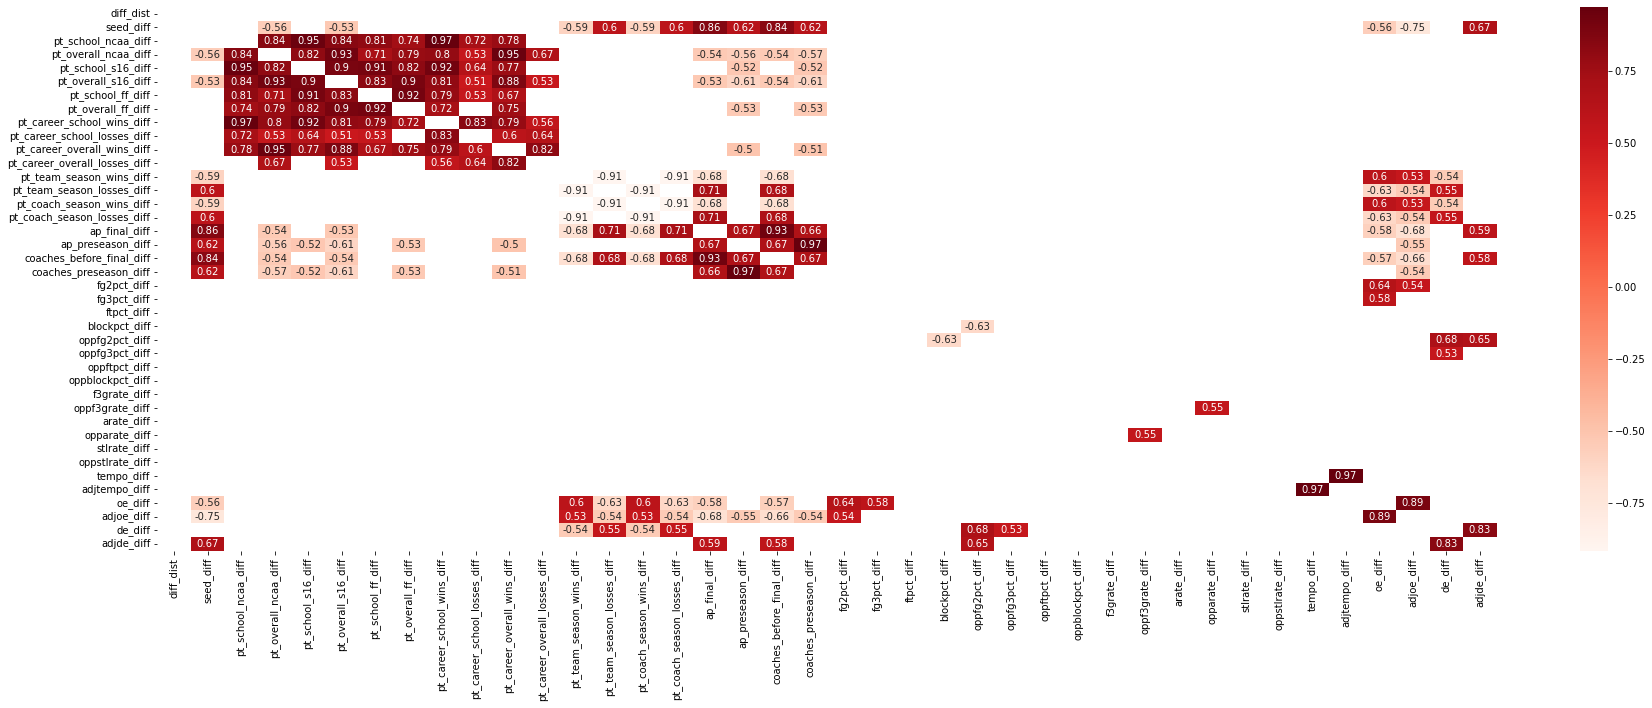

In [33]:
# this chart shows the complete list of variables 
# it only plots the pairings with a correlation greater than 5.0 or less than -0.5 
# which are the pairings that need to be discarded for models that are affected by multicollinearity
corr = mm_explore.corr()
filteredDf = corr[((corr >= .5) | (corr <= -.5)) & (corr !=1.000)]
plt.figure(figsize=(30,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

Based on the correlation matrix above, the following combination of variables were selected to avoid multicollinearity 
1. diff_dist
2. seed_diff
3. pt_career_overall_wins_diff
4. fg2pct_diff
5. fg3pct_diff
6. ftpct_diff
7. oppfg2pct_diff
8. oppftpct_diff
9. oppblockpct_diff
10. f3grate_diff
11. arate_diff
12. opparate_diff
13. stlrate_diff
14. oppstlrate_diff
15. tempo_diff

In [34]:
#Create Dataframe with variables of interest and join back the game detail columns dropped in the earlier step 
non_collinear_vars = ['diff_dist', 'seed_diff', 'pt_career_overall_wins_diff', 'fg2pct_diff',
                     'fg3pct_diff', 'ftpct_diff', 'oppfg2pct_diff', 'oppftpct_diff', 'oppblockpct_diff',
                     'f3grate_diff', 'f3grate_diff', 'arate_diff', 'opparate_diff', 'stlrate_diff',
                      'oppstlrate_diff', 'tempo_diff']

mm_reformatted_corr_removed = mm_reformatted[non_collinear_vars].join(game_details, how='inner')

Now that we have the variables, the next step is to remove the 2019 data from the dataset as this will be used to test the data for the competition. We will do this on the datasets with and without multicollinear variables (as the former will be used for the XGBoost model)


In [35]:
# DF WITHOUT MULTICOLLINEAR VARIABLES 
# remove season 2019
corr_removed_no2019 = mm_reformatted_corr_removed[mm_reformatted_corr_removed['season']!=2019].copy()
corr_removed_2019 = mm_reformatted_corr_removed[mm_reformatted_corr_removed['season']==2019].copy()

# store the game id of 2019 in a variable and delete the game id from the test and training sets
game_id_2019 = corr_removed_2019['game_id'].copy()
corr_removed_no2019.drop(columns=['game_id','season'], inplace=True)
corr_removed_2019.drop(columns=['game_id','season'], inplace=True)

In [36]:
# DF WITH MULTICOLLINEAR VARIABLES 
all_varsno2019 = mm_reformatted[mm_reformatted['season']!=2019].copy()
all_vars2019 = mm_reformatted[mm_reformatted['season']==2019].copy()

# store the game id of 2019 in a variable and delete the game id from the test and training sets
all_varsno2019.drop(columns=['game_id','season'], inplace=True)
all_vars2019.drop(columns=['game_id','season'], inplace=True)

## MODEL BUILDING

The following models were chosen for this analysis for the following reasons: 

1. Logistic Regression
    - serves as a good baseline model as it is easy to implement and train
    - can extract insights on feature importance based on the weights/ coefficients assigned to each one
    - Drawbacks: 1) sensitivity to multicollinearity 2) works best on linearly seperable data only 3) vulnerable to overfitting

2. SVM 
    - Because logistic regression works well with linearly seperable data, the RBF kernel is used as it is usually chosen for non-linear data. 
    - Additionally ,it is often used as a default when there is no prior knowledge regarding the dataset 
    - Drawback: difficult to decide which kernel works best. Selecting the wrong one will result it poor model performance
    - The following parameters will be tested for model tuning:
        - kernels (‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’)
        - gamma ('scale', 'auto')

3. Random Forest 
    - Because it is an ensemble of Decision Trees, it is less likely to overfit 
    - It generates Decision Trees at the same time and assesses the performance of each of them in parallel 
    - It is not sensitive to multicollinearity (so we can also test how the model works with all the aveailable features!)
    - The following parameters will be tested for model tuning:
        - max_depths = 3, 4, None 
        - criterion = 'gini', 'entropy', 'log_loss'
        - max_features = 'sqrt', 'log2', None 
    
3. XGBoost
    - Unlike the random forest model, it is a sequential model and it works by improving on the previous trees. 
    - Works with data that cannot be linearly separated 
    - Also not sensitive to multicollinearity
    - Drawback: difficult to adjust parameters, takes longer to run on this dataset compared to random forest
    - The following parameters will be tested  for model tuning: 
        - booster ('gbtree', 'gblinear', 'dart')
        - max_depth (4, 5, 6, 7)
        - tree_method ('auto', 'exact', 'approx', 'hist', 'gpu_hist')

## Model Tuning and Selection Process 
Additionally, the best algorithm will be assessed based on two criteria:
1. K-Fold Validation Score on the data excluding 2019 games (k=10)
    - 10 folds were chosen as this allows for the model to test on a large percentage of the data (10 is also the standard for k-fold validation, only very large datasets use lower k-fold values)
    - this method is good at selecting a general algorithm and parameters for tuning that will work best with the dataset 
    
2. Evaluating model based on performance predicting 2019 games 
    - Metrics such as accuracy, precision and recall will be analyzed
    - as well as log loss


### LOGISTIC REGRESSION

In [54]:
# LOGISTIC REGRESSION 

from sklearn.linear_model import Ridge


logreg = LogisticRegression()
kf=KFold(n_splits = 10)

features = corr_removed_no2019.loc[:, corr_removed_no2019.columns != 'team1_win']
target = corr_removed_no2019['team1_win']

logreg_score = cross_val_score(logreg, features, target, cv=kf)

print('Cross Validation Scores: ', logreg_score)
print('Average Cross Validation score :', logreg_score.mean())


Cross Validation Scores:  [0.60483871 0.61290323 0.62096774 0.7016129  0.65853659 0.56097561
 0.6097561  0.63414634 0.6504065  0.63414634]
Average Cross Validation score : 0.6288290060319958


### SUPPORT VECTOR MACHINES

In [64]:
# SVM 

# parameters 
# to test out more options for these parameters, add or change the values below 
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']

#for loop to test out diff combination of parameters 
for g in gamma:
    for k in kernels:
        svm_model = SVC(kernel = k, gamma = g, random_state = 1, probability=True)
        svm_score = cross_val_score(svm_model, features, target, cv=kf)
        print('kernel:', k, '|| gamma', g)
        # print(k, 'Cross Validation Scores:', svm_score) #uncomment to see scores for each fold
        print('Mean Cross Validation Score:', svm_score.mean())
        print('********')

kernel: linear || gamma scale
Mean Cross Validation Score: 0.6222856018882769
********
kernel: poly || gamma scale
Mean Cross Validation Score: 0.5291043797534749
********
kernel: rbf || gamma scale
Mean Cross Validation Score: 0.5672633097298715
********
kernel: sigmoid || gamma scale
Mean Cross Validation Score: 0.6126081825334382
********
kernel: linear || gamma auto
Mean Cross Validation Score: 0.6222856018882769
********
kernel: poly || gamma auto
Mean Cross Validation Score: 0.5282979281405716
********
kernel: rbf || gamma auto
Mean Cross Validation Score: 0.5672633097298715
********
kernel: sigmoid || gamma auto
Mean Cross Validation Score: 0.6150668764752163
********


### SVM Parameter Selection
Based on the results above, the SVM with a linear kernel and a gamma of scale or auto worked best as it garnered the highest mean cross validaiton score of 0.6222856018882769

### RANDOM FOREST

In [39]:
# Variables, including multicollinear ones will be inputted into the model 
# because the model is not sensitive to multicollinearity

features_allvars = all_varsno2019.loc[:, all_varsno2019.columns != 'team1_win']
target_allvars = all_varsno2019['team1_win']


In [55]:
# RANDOM FOREST 
# parameters
# to test out more options for these parameters, add or change the values below 
max_depths = [3, 4, None] #default is None  
criterion = ['gini', 'entropy', 'log_loss'] #default is gini 
max_features = ['sqrt', 'log2', None] #default is None

for d in max_depths:
    for c in criterion:
        for m in max_features:
            clf = RandomForestClassifier(max_depth = d, criterion = c, 
                                         max_features = m, random_state=1)

            print('max_depth:', d, '|| criterion:', c, '|| max_features:', m)
            print(np.mean(cross_val_score(clf, features_allvars, target_allvars, cv=10)))
            print('********')

max_depth: 3 || criterion: gini || max_features: sqrt
0.7091594544977708
********
max_depth: 3 || criterion: gini || max_features: log2
0.7091528979805928
********
max_depth: 3 || criterion: gini || max_features: None
0.7026553894571204
********
max_depth: 3 || criterion: entropy || max_features: sqrt
0.707520325203252
********
max_depth: 3 || criterion: entropy || max_features: log2
0.7083398898505113
********
max_depth: 3 || criterion: entropy || max_features: None
0.6961644374508261
********
max_depth: 3 || criterion: log_loss || max_features: sqrt
0.707520325203252
********
max_depth: 3 || criterion: log_loss || max_features: log2
0.7083398898505113
********
max_depth: 3 || criterion: log_loss || max_features: None
0.6961644374508261
********
max_depth: 4 || criterion: gini || max_features: sqrt
0.7050944138473643
********
max_depth: 4 || criterion: gini || max_features: log2
0.7018554943613953
********
max_depth: 4 || criterion: gini || max_features: None
0.7010228166797797
******

### Random Forest Parameter selection 
The following combination of the parameters garnerd the highest mean cross validation score of 0.710752688172043: max_depth: 4, criterion: log_loss, max_features: log2

### XGBOOST 

In [101]:
# XGBOOST 
# parameters
# to test out more options for these parameters, add or change the values below 

n_estimators = [50, 100, 150] # usual default is 100
# subsample = [0.5, 0.75, 1] # usual default is 1, uncomment and add to for loop to verify that changing these parameters will result in the same cross val score
# max_depth = [3, 6, 9] #usual default is 6, uncomment and add to for loop to verify that changing these parameters will result in the same cross val score
booster = ['dart', 'gbtree', 'gblinear'] 

for n in n_estimators:
    for b in booster:
        xg_clf = xgb.XGBClassifier(n_estimators = n, 
                                   booster = b,
                                  random_state = 1)

        print('n_estimators:', n, '|| booster:', b )
        print(np.mean(cross_val_score(clf, features_allvars, target_allvars, cv=10)))
        print('********')

n_estimators: 50 || booster: dart
0.6880736952530816
********
n_estimators: 50 || booster: gbtree
0.6880736952530816
********
n_estimators: 50 || booster: gblinear
0.6880736952530816
********
n_estimators: 100 || booster: dart
0.6880736952530816
********
n_estimators: 100 || booster: gbtree
0.6880736952530816
********
n_estimators: 100 || booster: gblinear
0.6880736952530816
********
n_estimators: 150 || booster: dart
0.6880736952530816
********
n_estimators: 150 || booster: gbtree
0.6880736952530816
********
n_estimators: 150 || booster: gblinear
0.6880736952530816
********


### XGBoost Parameter selection 
All combinations of the parameters tested above achieved the same mean cross validation score of 0.6880736952530816. 
Hence, for implementation, using any of the parameter combinations would suffice.


## TESTING THE MODELS ON 2019 GAMES

For the March Madness Competition Round 1, the results were tested on the 2019 season games. 
Thus, the models (with the best performing parameter combination) will be tested on how well it predicts the outcome of these games. 

In [62]:
# LogLoss Logistic Regression 

#set features and target variables for 2019 data
features_2019 = corr_removed_2019.loc[:, corr_removed_2019.columns != 'team1_win']
target_2019 = corr_removed_2019['team1_win']

#fit model using train data - which includes all season game variables that are not collinear, excluding 2019 data
logreg.fit(features, target)

#get logloss for 2019 data using log regression 
logloss_logreg = log_loss(target_2019, logreg.predict_proba(features_2019))
logloss_logreg

0.5208114245273641

In [69]:
# SVM model with best parameters 
svm_model_final = SVC(kernel = 'linear', gamma = 'scale', random_state = 1, probability=True)

#fit model using train data - which includes all season game variables that are not collinear, excluding 2019 data
svm_model_final.fit(features, target)

#get logloss for 2019 data using log regression 
logloss_svm = log_loss(target_2019, svm_model_final.predict_proba(features_2019))
logloss_svm

0.5322959783971801

In [76]:
# Random Forest with best parameters
rf_final = RandomForestClassifier(max_depth = 4, criterion = 'log_loss', max_features = 'log2', random_state=1)

#fit model using train data - which includes all season game variables, excluding 2019 data
features_allvars = all_varsno2019.loc[:, all_varsno2019.columns != 'team1_win']
target_allvars = all_varsno2019['team1_win']

# 2019 train and test data with all vars 
features_allvars2019 = all_vars2019.loc[:, all_vars2019.columns != 'team1_win']
target_allvars2019 = all_vars2019['team1_win']

rf_final.fit(features_allvars, target_allvars)

#get logloss for 2019 data using log regression 
logloss_rf = log_loss(target_allvars2019, rf_final.predict_proba(features_allvars2019))
logloss_rf

0.5343806478189952

In [100]:
# XGBoost with best parameters
# Different parameter combinations based on the cross val score testing can be tweaked below
# Though the cross val scores are identical, logloss differs depending on the parameter combination
# The selection below garnered the best logloss! 

xg_clf_final = xgb.XGBClassifier(n_estimators = 100, booster = 'gblinear', random_state = 1)

xg_clf_final.fit(features_allvars, target_allvars)

#get logloss for 2019 data using log regression 
logloss_xg = log_loss(target_allvars2019, xg_clf_final.predict_proba(features_allvars2019))
logloss_xg

0.4431846684091534

# FINAL EVALUATION: XGBOOST MODEL! 

Based on the logloss results on the 2019 data, it is evident that the XGBoost Model performed best, achieving the lowest logloss score of 0.4431 (which is only slightly higher than the 2019 kaggle champions with a score of 0.4148!)

Additionally, the XGBoost Model also garnered the highest mean cross validation score amongst all the models tested as well. 

Hence, this model is what will be used to predict the games for the 2023 march madness competition! 